### Test nanom6A on ELIGOS

In [1]:
fprs,tprs,precisions,recalls,normalization_roc,normalization_pr=[],[],[],[],[],[]

In [ ]:
#bash code

#normalA
find /home/wuyou/Projects/paper/ELIGOS_normalA/IVT_normalA_guppy_single/ -name "*.fast5" >normalA.txt

python /home/wuyou/Projects/nanom6A/nanom6A_2021_1_22/extract_raw_and_feature_fast.py --cpu=20 --fl=normalA.txt -o normalA --clip=10

python /home/wuyou/Projects/nanom6A/nanom6A_2021_1_22/predict_sites_simple.py --cpu 20 -i normalA -o normalA_final \
-r data/ref.fa -g data/anno.fa \
--model /home/wuyou/Projects/nanom6A/nanom6A_2021_3_11/bin/model




#m6A
find /home/wuyou/Projects/paper/ELIGOS_m6A/IVT_m6A_guppy_single/ -name "*.fast5" >m6A.txt

python /home/wuyou/Projects/nanom6A/nanom6A_2021_1_22/extract_raw_and_feature_fast.py --cpu=20 --fl=m6A.txt -o m6A --clip=10

python /home/wuyou/Projects/nanom6A/nanom6A_2021_1_22/predict_sites_simple.py --cpu 20 -i m6A -o m6A_final \
-r data/ref.fa -g data/anno.fa \
--model /home/wuyou/Projects/nanom6A/nanom6A_2021_1_22/bin/model

In [3]:
#calculate ROC and PR
from sklearn.metrics import roc_curve,auc,roc_auc_score,precision_recall_curve

batch_y,probabilities=[],[]

#cat *.mod *.unmod >normalA.predict
#cat *.mod *.unmod >m6A.predict

with open("/home/wuyou/Projects/paper/compare_with_other_models/nanom6A/normalA_final/normalA.predict") as f:
    count=0
    for i,line in enumerate(f):
        if i%100==0:
            probability=float(line.split("\t")[1])
            batch_y.append(0)
            probabilities.append(probability)
            if count>500:
                break
        
with open("/home/wuyou/Projects/paper/compare_with_other_models/nanom6A/m6A_final/m6A.predict") as f:
    count=0
    for i,line in enumerate(f):
        if i%100==0:
            probability=float(line.split("\t")[1])
            batch_y.append(1)
            probabilities.append(probability)
            if count>500:
                break



fpr,tpr,thersholds=roc_curve(batch_y,probabilities)
precision,recall,thersholds=precision_recall_curve(batch_y,probabilities)
roc_auc=auc(fpr,tpr)
pr_auc=auc(recall,precision)

fprs.extend(fpr)
tprs.extend(tpr)
precisions.extend(precision)
recalls.extend(recall)
normalization_roc.extend(["nanom6A AUC %.2f" %roc_auc]*len(fpr))
normalization_pr.extend(["nanom6A AUC %.2f" %pr_auc]*len(precision))


### Test tombo on ELIGOS

In [4]:
#calculate ROC and PR

from tombo import tombo_helper, tombo_stats, resquiggle
sample_per_read_stats_normal = tombo_stats.PerReadStats('/home/wuyou/Projects/paper/compare_with_other_models/tombo_normal.tombo.per_read_stats')
sample_per_read_stats_m6A = tombo_stats.PerReadStats('/home/wuyou/Projects/paper/compare_with_other_models/tombo_m6A.tombo.per_read_stats')


mod_dict_normal={"A1":{},"A2":{}}

reg_data = tombo_helper.intervalData(chrm="A1", start=1, end=2000, strand='+')
reg_per_read_stats_normal = sample_per_read_stats_normal.get_region_per_read_stats(reg_data)


for item in reg_per_read_stats_normal:
    pos=item[0]
    probability=item[1]
    if pos not in mod_dict_normal["A1"]:
        mod_dict_normal["A1"][pos]=[]
    mod_dict_normal["A1"][pos].append(probability)
    
reg_data = tombo_helper.intervalData(chrm="A2", start=1, end=2000, strand='+')
reg_per_read_stats_normal = sample_per_read_stats_normal.get_region_per_read_stats(reg_data)


for item in reg_per_read_stats_normal:
    pos=item[0]
    probability=item[1]
    if pos not in mod_dict_normal["A2"]:
        mod_dict_normal["A2"][pos]=[]
    mod_dict_normal["A2"][pos].append(probability)

mod_dict_m6A={"A1":{},"A2":{}}

reg_data = tombo_helper.intervalData(chrm="A1", start=1, end=2000, strand='+')
reg_per_read_stats_m6A = sample_per_read_stats_m6A.get_region_per_read_stats(reg_data)


for item in reg_per_read_stats_m6A:
    pos=item[0]
    probability=item[1]
    if pos not in mod_dict_m6A["A1"]:
        mod_dict_m6A["A1"][pos]=[]
    mod_dict_m6A["A1"][pos].append(probability)
    
reg_data = tombo_helper.intervalData(chrm="A2", start=1, end=2000, strand='+')
reg_per_read_stats_m6A = sample_per_read_stats_m6A.get_region_per_read_stats(reg_data)


for item in reg_per_read_stats_m6A:
    pos=item[0]
    probability=item[1]
    if pos not in mod_dict_m6A["A2"]:
        mod_dict_m6A["A2"][pos]=[]
    mod_dict_m6A["A2"][pos].append(probability)
    

probability=[]
label=[]

ref_dict={}
with open("/home/wuyou/Projects/paper/data/ELIGOS_A.fasta") as f:
    for line in f:
        line=line.strip()
        if ">" in line:
            contig=line[1:]
        else:
            sequence=line
            ref_dict[contig]=sequence

#RRACH
RRACH_motifs=["AAACA","AGACA","GAACA","GGACA",
       "AAACC","AGACC","GAACC","GGACC",
       "AAACT","AGACT","GAACT","GGACT",]

count=0
for contig in ref_dict:
    sequence=ref_dict[contig]

    for i in range(2,len(sequence)-3):
        motif=sequence[i-2:i+3]
        if motif in RRACH_motifs:
            probability_list=mod_dict_normal[contig][i+2]
            for j in range(int(len(probability_list)/100)):
                if count>2000:
                    break
                probability.append(1-probability_list[int(j*100)])
                label.append(0)
                count+=1
                
count=0
for contig in ref_dict:
    sequence=ref_dict[contig]

    for i in range(2,len(sequence)-3):
        motif=sequence[i-2:i+3]
        if motif in RRACH_motifs:
            probability_list=mod_dict_m6A[contig][i+2]
            for j in range(int(len(probability_list)/100)):
                if count>2000:
                    break
                probability.append(1-probability_list[int(j*100)])
                label.append(1)
                count+=1
                
fpr,tpr,thersholds=roc_curve(label,probability)
precision,recall,thersholds=precision_recall_curve(label,probability)
roc_auc=auc(fpr,tpr)
pr_auc=auc(recall,precision)



fprs.extend(fpr)
tprs.extend(tpr)
precisions.extend(precision)
recalls.extend(recall)
normalization_roc.extend(["tombo AUC %.2f" %roc_auc]*len(fpr))
normalization_pr.extend(["tombo AUC %.2f" %pr_auc]*len(precision))

#### Test TandemMod on ELIGOS

In [6]:
import argparse
import traceback
import re

import pandas as pd
import numpy as np
from scipy import interpolate

from sklearn import metrics
from sklearn import datasets
from sklearn.model_selection import train_test_split as ts
from sklearn.metrics import roc_curve,auc,roc_auc_score,precision_recall_curve

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.autograd import Variable

from plotnine import *
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device=",device)

black = '#222222'
gray = '#666666'
red = '#FF3333'
green = '#66CC00'
blue = '#3333FF'
purple = '#9933FF'
orange = '#FF8000'
yellow = '#FFFF33'



class Config:

    train_dir="m5C/feature/train/"
    test_dir="ELIGOS_C/feature/test/"
    #train_dir = "data/motif/CTCAC/train/"
    #test_dir = "data/motif/CTCAC/test/"
    batch_size = 500
    learning_rate=0.00001
    
    
kmer_encode_dic={'A': 0, "C": 1, "G": 2, "T": 3}   

class BahdanauAttention(nn.Module):
    """
    Bahdanau Attention mechanism module.

    Args:
        in_features (int): Number of input features.
        hidden_units (int): Number of hidden units.
        num_task (int): Number of tasks.

    """
    def __init__(self,in_features, hidden_units,num_task):
        super(BahdanauAttention,self).__init__()
        self.W1 = nn.Linear(in_features=in_features,out_features=hidden_units)
        self.W2 = nn.Linear(in_features=in_features,out_features=hidden_units)
        self.V = nn.Linear(in_features=hidden_units, out_features=num_task)

    def forward(self, hidden_states, values):
        """
        Forward pass of the Bahdanau Attention mechanism.

        Args:
            hidden_states (torch.Tensor): Hidden states tensor.
            values (torch.Tensor): Values tensor.

        Returns:
            torch.Tensor: Context vector.
            torch.Tensor: Attention weights.

        """
        hidden_with_time_axis = torch.unsqueeze(hidden_states,dim=1)

        score  = self.V(nn.Tanh()(self.W1(values)+self.W2(hidden_with_time_axis)))
        attention_weights = nn.Softmax(dim=1)(score)
        values = torch.transpose(values,1,2)   # transpose to make it suitable for matrix multiplication
        #print(attention_weights.shape,values.shape)
        context_vector = torch.matmul(values,attention_weights)
        context_vector = torch.transpose(context_vector,1,2)
        return context_vector, attention_weights

class TandemMod(nn.Module):
    def __init__(self,num_classes=2,vocab_zie=5, embedding_size=4,seq_len=5):
        super(TandemMod,self).__init__()

        self.seq_len=seq_len
        self.embed = nn.Embedding(vocab_zie, embedding_size)

        self.cnn_1d = nn.Sequential(
            nn.Conv1d(in_channels=1,out_channels=64,kernel_size=7,stride=2,padding=0),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Conv1d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,padding=1),
            nn.Dropout(p=0.2),
            nn.Conv1d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,padding=1),

        )
        self.lstm=nn.LSTM(input_size=128,hidden_size=128,batch_first=True,bidirectional=True)
        self.attention=BahdanauAttention(in_features=256,hidden_units=10,num_task=1)
        self.fc = nn.Sequential(
            nn.Linear(in_features=1536,out_features=1536),
            nn.ReLU(),
            nn.Linear(in_features=1536, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=2)
        )

        self.lstm_seq=nn.LSTM(input_size=4+5,hidden_size=128,batch_first=True,bidirectional=True)   #embedding_size+feature_num


    def seq_to_digit(self,seq):
        return torch.Tensor([{'A': 0, "C": 1, "G": 2, "T": 3}[i] for i in list(seq)]).long()


    def forward(self,x,kmer,mean,std,intense,dwell,base_quality):
        kmer_embedded=self.embed(kmer)
        mean = torch.reshape(mean, (-1, self.seq_len, 1)).float()
        std = torch.reshape(std, (-1, self.seq_len, 1)).float()
        intense = torch.reshape(intense, (-1, self.seq_len, 1)).float()
        dwell = torch.reshape(dwell, (-1, self.seq_len, 1)).float()
        base_quality = torch.reshape(base_quality, (-1, self.seq_len, 1)).float()
        
        out_seq=torch.cat((kmer_embedded,mean,std,intense,dwell,base_quality),2)


        out_seq,(h_n_seq,c_n_seq)=self.lstm_seq(out_seq)

        x = self.cnn_1d(x)

        batch_size, features, seq_len = x.size()
        x = x.view(batch_size, seq_len, features)  # parepare input for LSTM

        output, (h_n, c_n) = self.lstm(x)

        h_n = h_n.view(batch_size, output.size()[-1])  # pareprae input for Attention
        context_vector, attention_weights = self.attention(h_n, output)  # Attention (batch_size, num_task, unit)


        out=torch.cat((out_seq[:,0,:],out_seq[:,1,:],out_seq[:,2,:],out_seq[:,3,:],out_seq[:,4,:],context_vector[:,0,:]),1)
        #out=context_vector[:,0,:]
        out.view(out.size()[0],1,out.size()[1])
        x=self.fc(out)
        #x.view(x.size()[0], 1, x.size()[1])
        return x


class NN(TandemMod):
    def __init__(self):
        """
        Initialize the NN class.
        Inherits from the TandemMod class.
        """
        super(NN, self).__init__()

        
################median mad####################################################    
x_test_median_mad,y_test_median_mad=[],[]
kmer_fillter="[AG][AG]AC[ACT]"
f=open("/home/wuyou/Projects/paper/ELIGOS_normalA/feature/median_mad/ELIGOS_normalA")
count=0
for i,line in enumerate(f):
    if count>2e3:
        break
    
    
    line=line.rstrip()
    items=line.split("\t")
    contig=items[1]

    
    signals="|".join(items[9:14]).split("|")
    signal=np.array([float(signal) for signal in signals])
    #signal=(signal-np.mean(signal))/np.std(signal)
    kmer = items[3]
    list_have=[x.start() for x in re.finditer(kmer_fillter,kmer)]
    if len(list_have)==0:
        continue
    kmer=np.array([kmer_encode_dic[base] for base in kmer])
    mean = np.array([float(item) for item in items[4].split("|")])
    std = np.array([float(item) for item in items[5].split("|")])
    intense = np.array([float(item) for item in items[6].split("|")])
    dwell = np.array([float(item) for item in items[7].split("|")])/200
    base_quality = np.array([float(item) for item in items[8].split("|")])/40
    x=[signal, kmer, mean, std, intense, dwell,base_quality]
    x_test_median_mad.append(x)
    y_test_median_mad.append(0)
    count+=1
f.close()


f=open("/home/wuyou/Projects/paper/ELIGOS_m6A/feature/median_mad/ELIGOS_m6A")
count=0
for i,line in enumerate(f):
    if count>2e3:
        break
    
    
    line=line.rstrip()
    items=line.split("\t")
    
    contig=items[1]

        
    signals="|".join(items[9:14]).split("|")
    signal=np.array([float(signal) for signal in signals])
    #signal=(signal-np.mean(signal))/np.std(signal)
    kmer = items[3]
    list_have=[x.start() for x in re.finditer(kmer_fillter,kmer)]
    if len(list_have)==0:
        continue
        
    kmer=np.array([kmer_encode_dic[base] for base in kmer])
    mean = np.array([float(item) for item in items[4].split("|")])
    std = np.array([float(item) for item in items[5].split("|")])
    intense = np.array([float(item) for item in items[6].split("|")])
    dwell = np.array([float(item) for item in items[7].split("|")])/200
    base_quality = np.array([float(item) for item in items[8].split("|")])/40
    x=[signal, kmer, mean, std, intense, dwell,base_quality]
    x_test_median_mad.append(x)
    y_test_median_mad.append(1)
    count+=1
f.close()



class MyDataset(Dataset):
    """
    Custom dataset class.

    Args:
        x (list or numpy array): Input data.
        y (list or numpy array): Target data.

    """
    def __init__(self,x,y):
        self.x=x
        self.y=y

    def __getitem__(self, index):
        return self.x[index],self.y[index]

    def __len__(self):
        return len(self.x)


def make_weights_for_balanced_classes(images, nclasses):
    """
    Computes weights for balancing classes in a dataset.

    Args:
        images (list): List of images.
        nclasses (int): Number of classes.

    Returns:
        list: List of weights.

    """
    count = [0] * nclasses
    for item in images:
        count[item[1]] += 1
    weight_per_class = [0.] * nclasses
    N = float(sum(count))
    for i in range(nclasses):
        weight_per_class[i] = N/float(count[i])
    weight = [0] * len(images)
    for idx, val in enumerate(images):
        weight[idx] = weight_per_class[val[1]]
    return weight

from torch.utils.data import WeightedRandomSampler
class CustomWeightedRandomSampler(WeightedRandomSampler):
    """
    Custom implementation of WeightedRandomSampler.
    WeightedRandomSampler except allows for more than 2^24 samples to be sampled
    Args:
        *args: Variable length argument list.
        **kwargs: Arbitrary keyword arguments.

    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __iter__(self):
        rand_tensor = np.random.choice(range(0, len(self.weights)),
                                       size=self.num_samples,
                                       p=self.weights.numpy() / torch.sum(self.weights).numpy(),
                                       replace=self.replacement)
        rand_tensor = torch.from_numpy(rand_tensor)
        return iter(rand_tensor.tolist())

print("loading data...")

model = TandemMod(num_classes=2,vocab_zie=5, embedding_size=4,seq_len=5).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

loss_func = torch.nn.CrossEntropyLoss()#.to(device)
#predict_result=open("rice/results/WT_precit_results.tsv","w")

def predict(model,dataset,cut_off_threshold):

    dataloader=torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=2000, 
                                           shuffle=True,
                                           num_workers=36,
                                           pin_memory=True)

    try:

        test_acc = 0.
        y_test = []
        y_pred = []
        label_dict={0:"m5C",1:"C"}

        for i,(batch_x, batch_y) in enumerate(dataloader):

            signal, kmer, mean, std, intense, dwell,base_quality = batch_x
            signal= Variable(signal.to(device)).to(torch.float32)

            kmer = Variable(kmer.to(device)).to(torch.long)
            mean = Variable(mean.to(device)).to(torch.float32)
            std = Variable(std.to(device)).to(torch.float32)
            intense = Variable(intense.to(device)).to(torch.float32)
            dwell = Variable(dwell.to(device)).to(torch.float32)
            base_quality = Variable(base_quality.to(device)).to(torch.float32)
            batch_size, features = signal.size()
            signal = signal.view(batch_size, 1, features)

            out = model(signal, kmer, mean, std, intense, dwell,base_quality )
            batch_size, out_channels = out.size()

            out = out.view(batch_size, out_channels)
            pred = torch.max(out, 1)[1].numpy()

            out=torch.softmax(out,dim=1)
            probabilities=out.detach().numpy()[:,1]
            batch_y=batch_y.detach().numpy()
            #print(probabilities)
            
            selected_batch_y=[]
            selected_probabilities=[]
            for j in range(len(batch_y)):
                if probabilities[j]<cut_off_threshold[0] or probabilities[j]>cut_off_threshold[1]:
                    selected_batch_y.append(batch_y[j])
                    selected_probabilities.append(probabilities[j])
            
            #print(cut_off_threshold[0],len(selected_batch_y))
            fpr,tpr,thersholds=roc_curve(selected_batch_y,selected_probabilities)
            precision,recall,thersholds=precision_recall_curve(selected_batch_y,selected_probabilities)
            
            roc_auc=auc(fpr,tpr)
            pr_auc=auc(recall,precision)
            
            return fpr,tpr,precision,recall,roc_auc,pr_auc
            
    except Exception as e:
        print(e)
        traceback.print_exc()
        
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Extract feature from signal.')
    parser.add_argument('-feature', default='BaseCalled_template',help='Basecall subgroup Nanoraw resquiggle into. Default is BaseCalled_template')
    args = parser.parse_args()

    dataset=MyDataset(x_test_median_mad,y_test_median_mad)
    
    model= torch.load('/home/wuyou/Projects/paper/model/m6A_Os_AD_median_mad_2.21.pkl')
    fpr,tpr,precision,recall,roc_auc_MMAD,pr_auc_MMAD=predict(model,dataset,[0.5,0.5])
    fprs.extend(fpr)
    tprs.extend(tpr)
    precisions.extend(precision)
    recalls.extend(recall)
    normalization_roc.extend(["TandemMod AUC %.2f" %roc_auc_MMAD]*len(fpr))
    normalization_pr.extend(["TandemMod AUC %.2f" %pr_auc_MMAD]*len(precision))
    
    
    roc_auc = auc(fpr, tpr)

device= cpu
loading data...
[6.6741356e-03 4.1540785e-04 9.4834358e-01 ... 3.4909749e-01 9.9098599e-01
 9.4304490e-01]
0.5 2000


### Plot

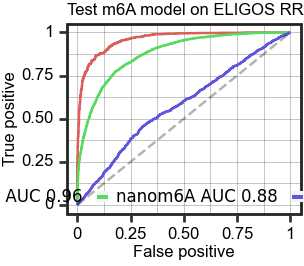

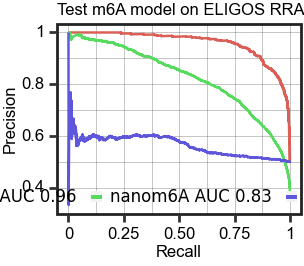

In [7]:
from plotnine import *
import pandas as pd

data=pd.DataFrame(dict(fpr=fprs,tpr=tprs,normalization=normalization_roc)) 
p1 = (ggplot()
            +geom_line(data,aes(x="fpr",y = "tpr",group="normalization",color='normalization'))
            +geom_line(pd.DataFrame(dict(x=[0,1],y=[0,1])),aes(x="x",y="y"),linetype="dashed",alpha=0.3)
            +theme(panel_background=element_rect(fill=gray, alpha=0),
                panel_grid_major=element_line(size=0.3, alpha=0.3,color=black),
                panel_grid_minor=element_line(size=0.3, alpha=0.3,color=black),
                panel_border=element_rect(color=black, size=1),
                axis_text=element_text(size=6,family="Arial",color="black"),
                axis_title_x=element_text(size=6,family="Arial",color="black"),
                axis_title_y=element_text(size=6,family="Arial",color="black"),
                plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black"),
                figure_size=[1.52,1.33],
                legend_title = element_text(size=6), #change legend title font size
                legend_text = element_text(size=6),
                legend_background=element_rect(size=0.5,alpha=0),
                legend_position=(0.54,0.3),
                legend_key_size=4) #change legend text font size
            +labs(x = "False positive", y ="True positive")
            +guides(color = guide_legend(title = ""))
            +ggtitle("Test m6A model on ELIGOS RRACH motif")

    )
print(p1)
p1.save('figure/figure_2h_ROC_performance_comparision_RRACH.pdf')

data=pd.DataFrame(dict(precision=precisions,recall=recalls,normalization=normalization_pr)) 
p2 = (ggplot()
            #+geom_line(pd.DataFrame(dict(x=[1,0],y=[0,1])),aes(x="x",y="y"),linetype="dashed")
            +geom_line(data,aes(x="recall",y = "precision",group="normalization",color='normalization'))

            +theme(panel_background=element_rect(fill=gray, alpha=0),
                panel_grid_major=element_line(size=0.3, alpha=0.3,color=black),
                panel_grid_minor=element_line(size=0.3, alpha=0.3,color=black),
                panel_border=element_rect(color=black, size=1),
                axis_text=element_text(size=6,family="Arial",color="black"),
                axis_title_x=element_text(size=6,family="Arial",color="black"),
                axis_title_y=element_text(size=6,family="Arial",color="black"),
                plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black"),
                figure_size=[1.52,1.33],
                legend_title = element_text(size=6), #change legend title font size
                legend_text = element_text(size=6),
                legend_background=element_rect(size=0.5,alpha=0),
                legend_position=(0.52,0.3), 
                legend_key_size=4) #change legend text font size)
            +labs(x = "Recall", y ="Precision")
            +ggtitle("Test m6A model on ELIGOS RRACH motif")
            +guides(color = guide_legend(title = ""))
            )
print(p2)
p2.save('figure/figure_2h_PR_performance_comparision_RRACH.pdf')